# Car Fuel Efficiency Regression Homework Solution
This Jupyter Notebook walks through all tasks in the assignment, including EDA, data preparation, model training, and evaluation for questions 1–6.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = pd.read_csv(url)

In [3]:
# Filter relevant columns
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]

In [4]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## EDA 

In [6]:
# Filter relevant column
fe = df['fuel_efficiency_mpg']

In [7]:
# Summary statistics
print(fe.describe())


count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64


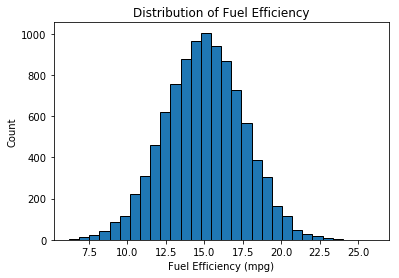

In [8]:
# Histogram
plt.hist(fe, bins=30, edgecolor='k')
plt.xlabel('Fuel Efficiency (mpg)')
plt.ylabel('Count')
plt.title('Distribution of Fuel Efficiency')
plt.show()

Min: 6.2

Max: 25.97

Median (50%): 15.0

Mean: 14.99

Observations:

The mean and median are very close, suggesting a roughly symmetric distribution around the center.

However, the maximum value (≈26) is quite a bit higher than the 75th percentile (≈16.7). That indicates there are some unusually high values.

The minimum is much lower than the mean, but the lower values are closer to the 25th percentile, so the extreme is more on the high side.

✅ Conclusion: The distribution has a long right tail (skewed to higher mpg), meaning a few cars are much more fuel-efficient than the majority.

In [9]:
# Q1: Which column has missing values?
print(df.isna().sum())
# Answer: 'horsepower'


engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


In [10]:
# Q2: Median of horsepower
print(df['horsepower'].median())
# Answer: 149

149.0


In [11]:
# Prepare and split dataset
def split_data(seed):
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    n = len(df_shuffled)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    df_train = df_shuffled.iloc[:n_train]
    df_val = df_shuffled.iloc[n_train:n_train+n_val]
    df_test = df_shuffled.iloc[n_train+n_val:]
    return df_train, df_val, df_test

In [12]:
df_train, df_val, df_test = split_data(42)

In [14]:
# Q3: Fill missing horsepower with 0 or mean and evaluate
for method in ['zero', 'mean']:
    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    if method == 'zero':
        df_train_copy['horsepower'] = df_train_copy['horsepower'].fillna(0)
        df_val_copy['horsepower'] = df_val_copy['horsepower'].fillna(0)
    else:
        mean_hp = df_train_copy['horsepower'].mean()
        df_train_copy['horsepower'] = df_train_copy['horsepower'].fillna(mean_hp)
        df_val_copy['horsepower'] = df_val_copy['horsepower'].fillna(mean_hp)

    X_train = df_train_copy.drop('fuel_efficiency_mpg', axis=1)
    y_train = df_train_copy['fuel_efficiency_mpg']
    X_val = df_val_copy.drop('fuel_efficiency_mpg', axis=1)
    y_val = df_val_copy['fuel_efficiency_mpg']

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(method, round(rmse, 2))
# Answer: Choose the option with lower RMSE

zero 0.52
mean 0.46


With the mean, we obtain a lower RMSE

In [20]:
# Q4: Regularized linear regression (Ridge) with NAs filled with 0
df_train, df_val, _ = split_data(42)
for col in ['horsepower']:
    df_train[col] = df_train[col].fillna(0)
    df_val[col] = df_val[col].fillna(0)

X_train = df_train.drop('fuel_efficiency_mpg', axis=1)
y_train = df_train['fuel_efficiency_mpg']
X_val = df_val.drop('fuel_efficiency_mpg', axis=1)
y_val = df_val['fuel_efficiency_mpg']

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
best_rmse = float('inf')
best_r = None
for r in r_list:
    model = Ridge(alpha=r)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(r, round(rmse, 2))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_r = r
    
print("Best r:", best_r)
# Answer: best_r

0 0.52
0.01 0.52
0.1 0.52
1 0.52
5 0.52
10 0.52
100 0.52
Best r: 0


In [24]:
# Q5: Effect of seed
# Function to split dataset
def split_data(seed):
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    n = len(df_shuffled)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    df_train = df_shuffled.iloc[:n_train]
    df_val = df_shuffled.iloc[n_train:n_train+n_val]
    df_test = df_shuffled.iloc[n_train+n_val:]
    return df_train, df_val, df_test

seeds = list(range(10))
rmse_list = []

for seed in seeds:
    df_train, df_val, _ = split_data(seed)
    
    # Fill missing horsepower with 0
    df_train['horsepower'] = df_train['horsepower'].fillna(0)
    df_val['horsepower'] = df_val['horsepower'].fillna(0)
    
    # Prepare features and target
    X_train = df_train.drop('fuel_efficiency_mpg', axis=1)
    y_train = df_train['fuel_efficiency_mpg']
    X_val = df_val.drop('fuel_efficiency_mpg', axis=1)
    y_val = df_val['fuel_efficiency_mpg']
    
    # Train linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Predict and compute RMSE manually
    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_list.append(rmse)

# Compute standard deviation of RMSEs
std_rmse = round(np.std(rmse_list), 3)
print("RMSEs:", [round(r, 3) for r in rmse_list])
print("Std of RMSEs:", std_rmse)

RMSEs: [0.521, 0.522, 0.523, 0.516, 0.511, 0.529, 0.532, 0.51, 0.515, 0.513]
Std of RMSEs: 0.007


In [26]:
# Q6: Train on train+val, seed=9, r=0.001
df_train, df_val, df_test = split_data(9)
df_combined = pd.concat([df_train, df_val])
df_combined['horsepower'] = df_combined['horsepower'].fillna(0)
df_test['horsepower'] = df_test['horsepower'].fillna(0)

X_train = df_combined.drop('fuel_efficiency_mpg', axis=1)
y_train = df_combined['fuel_efficiency_mpg']
X_test = df_test.drop('fuel_efficiency_mpg', axis=1)
y_test = df_test['fuel_efficiency_mpg']

model = Ridge(alpha=0.001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", round(rmse, 3))

Test RMSE: 0.515
